In [479]:
import pandas as pd
from datetime import datetime, timedelta, date
import io

colorado_df = pd.read_csv("data/states/colorado/colorado.csv", error_bad_lines=True)
colorado_df = colorado_df[(colorado_df['occcounty'] < 8999)]

county_pop_df = pd.read_csv("data/states/county_pop.csv", encoding = "utf-8",error_bad_lines=True)
county_pop_df = county_pop_df[county_pop_df['STNAME'] == 'Colorado']

#yearly_deaths_by_code = weekly_deaths_df[(weekly_deaths_df['week'] <= 34) & (weekly_deaths_df['year'] == 2019)].groupby(['ucod'])['total_deaths'].sum()
#yearly_deaths_by_code_df = yearly_deaths_by_code.to_frame(name = 'yearly_deaths').sort_values(['yearly_deaths', 'ucod'],ascending=False).reset_index().head(26)
#top_ucodes = yearly_deaths_by_code_df['ucod']
#weekly_deaths_df= weekly_deaths_df[(weekly_deaths_df['ucod'].isin(top_ucodes))]

#pulm_categories =['J449','I251','C349','I219','I500','I250','I64','I119','I48','F019','I110','J189']
#non_pulm_categories =['G309','F03','C259','C509','G20','C61','C189','K703','W19','X70','C80','X74','A419','X44']
#top_ucodes = pulm_categories + non_pulm_categories

colorado_df['cat'] = ''
#colorado_df.loc[colorado_df['ucod'].isin(pulm_categories), "cat"] = 'P'
#colorado_df.loc[colorado_df['acme2'].isin(pulm_categories), "cat"] = 'P'
#colorado_df.loc[colorado_df['ucod'].isin(non_pulm_categories), "cat"] = 'NP'
#colorado_df.loc[colorado_df['acme2'].isin(non_pulm_categories), "cat"] = 'NP'

#colorado_df = colorado_df[(colorado_df['ucod'].isin(top_ucodes) | (colorado_df['acme2'].isin(top_ucodes)))]

weekly_deaths_df = colorado_df.groupby(['occcounty', 'year','dwk','cat'])['deaths'].agg(['sum']).reset_index()
weekly_deaths_df = weekly_deaths_df.rename(columns={'occcounty':'county','dwk' : 'week', 'sum':'total_deaths'})


county_2017_pop= dict(zip(county_pop_df.COUNTY,county_pop_df.POPESTIMATE2017))
pop_100k = 100000.0
weekly_deaths_df['pop'] = 0
weekly_deaths_df['total_deaths_per100k'] = 0
weekly_deaths_df['excess_deaths_per100k'] = 0
for index, row in weekly_deaths_df.iterrows():
    county = row['county'] - 8000
    weekly_deaths_df.at[index,'pop'] = county_2017_pop[county]
    weekly_deaths_df.at[index, 'total_deaths_per100k'] = row["total_deaths"] #(row["total_deaths"] *pop_100k )/(county_2017_pop[county]* 1.0)


avg_deaths = weekly_deaths_df[weekly_deaths_df['year'] < 2020].groupby(['county', 'week','cat'])['total_deaths_per100k'].mean()
avg_deaths_df = avg_deaths.to_frame(name = 'avg_deaths').reset_index()

for index, row in weekly_deaths_df.iterrows():
    year = row['year']
    county = row['county']
    week = row['week']
    cat = row['cat']
    if year == 2020:
        avgd = avg_deaths_df[(avg_deaths_df['county'] == county) & (avg_deaths_df['week'] == week) & (avg_deaths_df['cat'] == cat)]
        if not avgd.empty:
            weekly_deaths_df.at[index, "excess_deaths_per100k"] = row['total_deaths_per100k'] - avgd['avg_deaths']      
weekly_deaths_df["county"] = pd.to_numeric(weekly_deaths_df["county"], downcast='float')


 

In [480]:
weekly_deaths_df = weekly_deaths_df[(weekly_deaths_df['year'] ==2020)  & (weekly_deaths_df['week'] <= 30)]
weekly_deaths_df[(weekly_deaths_df['year'] ==2020) ].groupby('year')['total_deaths_per100k'].sum()
weekly_deaths_df

,county,year,week,cat,total_deaths,pop,total_deaths_per100k,excess_deaths_per100k
265,8001.0,2020,0,,36,503590,36,-1
266,8001.0,2020,1,,73,503590,73,0
267,8001.0,2020,2,,65,503590,65,-2
268,8001.0,2020,3,,89,503590,89,28
269,8001.0,2020,4,,81,503590,81,12
...,...,...,...,...,...,...,...,...
13422,8125.0,2020,26,,4,9959,4,3
13423,8125.0,2020,27,,2,9959,2,0
13424,8125.0,2020,28,,2,9959,2,0
13425,8125.0,2020,29,,2,9959,2,-1


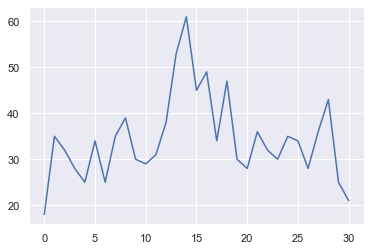

In [481]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = weekly_deaths_df[(weekly_deaths_df['year'] ==2020) &(weekly_deaths_df['county'] == 8123)]['week']
y = weekly_deaths_df[(weekly_deaths_df['year'] ==2020) &(weekly_deaths_df['county'] == 8123)]['total_deaths_per100k']
plt.plot(x, y)

In [482]:
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2',  'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])

US_Cases_df = US_Cases_df[(US_Cases_df['Province_State'] == 'Colorado') | (US_Cases_df['Province_State'] == 'Utah')]
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS','Province_State'], 
        var_name="Date", 
        value_name="Value")

US_Cases_df['Date']= pd.to_datetime(US_Cases_df['Date'])
US_Cases_df['week'] = US_Cases_df['Date'].dt.week
weekly_covid_cases_df = US_Cases_df.groupby(['FIPS', 'week'])['Value'].sum()
weekly_covid_cases_df = weekly_covid_cases_df.to_frame(name = 'weekly_cases').reset_index()

Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Deaths_df = US_Deaths_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Population', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df = US_Deaths_df.fillna(0)#US_Cases_df.dropna(subset=['FIPS'])

US_Deaths_df = US_Deaths_df[(US_Deaths_df['Province_State'] == 'Colorado') | (US_Deaths_df['Province_State'] == 'Utah')]

US_Deaths_df = US_Deaths_df.melt(id_vars=['FIPS','Province_State'], 
        var_name="Date", 
        value_name="Value")

US_Deaths_df['Date']= pd.to_datetime(US_Deaths_df['Date'])
US_Deaths_df['week'] = US_Deaths_df['Date'].dt.week
weekly_covid_deaths_df = US_Deaths_df.groupby(['FIPS', 'week'])['Value'].sum()
weekly_covid_deaths_df = weekly_covid_deaths_df.to_frame(name = 'weekly_deaths').reset_index()
weekly_covid_deaths_df["FIPS"] = pd.to_numeric(weekly_covid_deaths_df["FIPS"], downcast="float")


In [483]:

county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates = county_covariates[(county_covariates['State'] == 'CO') | (county_covariates['State'] == 'UT')]
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
covariates = covariates.fillna(0)

covariates = covariates.dropna(axis='columns')

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races']]
 

In [484]:
covariates['TOT_POP'].sum()

8856669

In [485]:

def merge_dataset(weekly_total_deaths_df, weekly_deaths_df, weekly_cases_df): 
    weekly_deaths_prior_one_weeks_df = weekly_deaths_df.copy() 
    weekly_deaths_prior_one_weeks_df["week"] = weekly_deaths_prior_one_weeks_df["week"] + 1
    weekly_deaths_prior_one_weeks_df.rename(columns = {'weekly_deaths':'one_week_prior_weekly_deaths'}, inplace = True)
    
    weekly_deaths_prior_two_weeks_df = weekly_deaths_df.copy() 
    weekly_deaths_prior_two_weeks_df["week"] = weekly_deaths_prior_two_weeks_df["week"] + 2
    weekly_deaths_prior_two_weeks_df.rename(columns = {'weekly_deaths':'two_week_prior_weekly_deaths'}, inplace = True)
    
    weekly_deaths_prior_three_weeks_df = weekly_deaths_df.copy() 
    weekly_deaths_prior_three_weeks_df["week"] = weekly_deaths_prior_three_weeks_df["week"] + 3
    weekly_deaths_prior_three_weeks_df.rename(columns = {'weekly_deaths':'three_week_prior_weekly_deaths'}, inplace = True)
    
    weekly_deaths_merged_df = weekly_total_deaths_df.merge(weekly_deaths_prior_two_weeks_df[['two_week_prior_weekly_deaths',  'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS',  'week'])
    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_deaths_prior_three_weeks_df[['three_week_prior_weekly_deaths', 'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS', 'week'])
    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_deaths_prior_one_weeks_df[['one_week_prior_weekly_deaths', 'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS', 'week'])

    
    weekly_cases_prior_two_weeks_df = weekly_cases_df.copy() 
    weekly_cases_prior_two_weeks_df["week"] = weekly_cases_df["week"] + 2
    weekly_cases_prior_two_weeks_df.rename(columns = {'weekly_cases':'two_week_prior_weekly_cases'}, inplace = True)
    weekly_cases_prior_three_weeks_df = weekly_cases_df.copy() 
    weekly_cases_prior_three_weeks_df["week"] = weekly_cases_df["week"] + 3
    weekly_cases_prior_three_weeks_df.rename(columns = {'weekly_cases':'three_week_prior_weekly_cases'}, inplace = True)

    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_cases_prior_two_weeks_df[['two_week_prior_weekly_cases', 'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS',  'week'])
    weekly_deaths_merged_df = weekly_deaths_merged_df.merge(weekly_cases_prior_three_weeks_df[['three_week_prior_weekly_cases', 'FIPS', 'week']], how='left', left_on=['county',  'week'], right_on=['FIPS',  'week'])
    return weekly_deaths_merged_df

In [486]:
weekly_deaths_merged_df = merge_dataset(weekly_deaths_df[weekly_deaths_df['cat'] == ''],weekly_covid_deaths_df,weekly_covid_cases_df) 


In [487]:

covariates_merged = covariates.merge(weekly_deaths_merged_df[['one_week_prior_weekly_deaths',
                                                                                'two_week_prior_weekly_deaths', 
                                                              'three_week_prior_weekly_deaths',                 
                                                              'two_week_prior_weekly_cases',
                                                              'three_week_prior_weekly_cases',
                                            'county', 'year', 'week']], how='inner', left_on=["fips"], right_on=['county'])


In [488]:
weekly_deaths_prior_one_weeks_df = weekly_covid_deaths_df.copy() 
weekly_deaths_prior_one_weeks_df["week"] = weekly_deaths_prior_one_weeks_df["week"] + 1
weekly_deaths_prior_one_weeks_df.rename(columns = {'weekly_deaths':'one_week_prior_weekly_deaths'}, inplace = True)

weekly_deaths_prior_two_weeks_df = weekly_covid_deaths_df.copy() 
weekly_deaths_prior_two_weeks_df["week"] = weekly_deaths_prior_two_weeks_df["week"] + 2
weekly_deaths_prior_two_weeks_df.rename(columns = {'weekly_deaths':'two_week_prior_weekly_deaths'}, inplace = True)

weekly_deaths_prior_three_weeks_df = weekly_covid_deaths_df.copy() 
weekly_deaths_prior_three_weeks_df["week"] = weekly_deaths_prior_three_weeks_df["week"] + 3
weekly_deaths_prior_three_weeks_df.rename(columns = {'weekly_deaths':'three_week_prior_weekly_deaths'}, inplace = True)

weekly_cases_prior_two_weeks_df = weekly_covid_cases_df.copy() 
weekly_cases_prior_two_weeks_df["week"] = weekly_covid_cases_df["week"] + 2
weekly_cases_prior_two_weeks_df.rename(columns = {'weekly_cases':'two_week_prior_weekly_cases'}, inplace = True)
weekly_cases_prior_three_weeks_df = weekly_covid_cases_df.copy() 
weekly_cases_prior_three_weeks_df["week"] = weekly_covid_cases_df["week"] + 3
weekly_cases_prior_three_weeks_df.rename(columns = {'weekly_cases':'three_week_prior_weekly_cases'}, inplace = True)


covariates["fips"] = pd.to_numeric(covariates["fips"], downcast="float")

covariates_ut = covariates[(covariates['fips'] > 49000) & (covariates['fips'] <= 49057)]

covariates_merged_ut = covariates_ut.merge(weekly_deaths_prior_one_weeks_df[['one_week_prior_weekly_deaths', 'FIPS', 'week']], how='left', left_on=['fips'], right_on=['FIPS'])
covariates_merged_ut = covariates_merged_ut.merge(weekly_deaths_prior_two_weeks_df[['two_week_prior_weekly_deaths',  'FIPS', 'week']], how='left', left_on=['fips', 'week'], right_on=['FIPS', 'week'])
covariates_merged_ut = covariates_merged_ut.merge(weekly_deaths_prior_three_weeks_df[['three_week_prior_weekly_deaths', 'FIPS', 'week']], how='left', left_on=['fips', 'week'], right_on=['FIPS', 'week'])

covariates_merged_ut = covariates_merged_ut.merge(weekly_cases_prior_two_weeks_df[['two_week_prior_weekly_cases', 'FIPS', 'week']], how='left', left_on=['fips', 'week'], right_on=['FIPS', 'week'])
covariates_merged_ut = covariates_merged_ut.merge(weekly_cases_prior_three_weeks_df[['three_week_prior_weekly_cases', 'FIPS', 'week']], how='left', left_on=['fips', 'week'], right_on=['FIPS', 'week'])
covariates_merged_ut.drop(['FIPS_x','FIPS_y', 'FIPS','fips'], axis=1, inplace=True)
covariates_merged.drop(['county', 'year', 'fips'], axis=1, inplace=True)
covariates_merged_ut = covariates_merged_ut[[ 'TOT_POP', '0-9', '0-9 y/o % of total pop', '10-19', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'one_week_prior_weekly_deaths', 'two_week_prior_weekly_deaths', 'three_week_prior_weekly_deaths', 'two_week_prior_weekly_cases', 'three_week_prior_weekly_cases', 'week']]


In [495]:
covariates_merged_ut[covariates_merged_ut['two_week_prior_weekly_deaths'] > 0]

,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,...,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,one_week_prior_weekly_deaths,two_week_prior_weekly_deaths,three_week_prior_weekly_deaths,two_week_prior_weekly_cases,three_week_prior_weekly_cases,week
249,351713,61706,17.544418,60675,17.251282,47577,13.527222,52524,14.933767,43964,...,2821,0.802074,9515,2.705331,7,1.0,0.0,65.0,8.0,14
250,351713,61706,17.544418,60675,17.251282,47577,13.527222,52524,14.933767,43964,...,2821,0.802074,9515,2.705331,9,7.0,1.0,312.0,65.0,15
251,351713,61706,17.544418,60675,17.251282,47577,13.527222,52524,14.933767,43964,...,2821,0.802074,9515,2.705331,14,9.0,7.0,749.0,312.0,16
252,351713,61706,17.544418,60675,17.251282,47577,13.527222,52524,14.933767,43964,...,2821,0.802074,9515,2.705331,14,14.0,9.0,1217.0,749.0,17
253,351713,61706,17.544418,60675,17.251282,47577,13.527222,52524,14.933767,43964,...,2821,0.802074,9515,2.705331,14,14.0,14.0,1545.0,1217.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,33240,5456,16.413959,5869,17.656438,3705,11.146209,4442,13.363418,4468,...,77,0.231649,568,1.708785,88,91.0,91.0,18401.0,16508.0,52
1258,171700,23775,13.846826,25574,14.894584,20687,12.048340,20407,11.885265,17793,...,1621,0.944089,3705,2.157833,7,1.0,0.0,53.0,0.0,15
1259,171700,23775,13.846826,25574,14.894584,20687,12.048340,20407,11.885265,17793,...,1621,0.944089,3705,2.157833,7,7.0,1.0,136.0,53.0,16
1260,171700,23775,13.846826,25574,14.894584,20687,12.048340,20407,11.885265,17793,...,1621,0.944089,3705,2.157833,6,7.0,7.0,249.0,136.0,17


In [489]:
from sklearn.model_selection import StratifiedKFold
def run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
              covariates_merged,weekly_deaths_merged_df,predict_column_index,best_fit_scores,index):
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['week'].isin(train_week))] 
    weekly_deaths_train_week = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(train_week))].iloc[:, predict_column_index]  
    if len(weekly_deaths_merged_df) > 0:
       
        X_train = covariates_train_week
        Y_train = weekly_deaths_train_week
        #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
        xgbReg = xgb.XGBRegressor()

        parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
              'max_depth': [1,2,3,4],
              'min_child_weight': [1,2],
              'subsample': [0.8],
              'colsample_bytree' : [0.8],
              'n_estimators': [ 100,200]}
        tscv = StratifiedKFold(n_splits=2, shuffle=False, random_state = None)
        xgb_grid = GridSearchCV(xgbReg,
                        parameters,
                        cv = tscv,
                        n_jobs = 4,
                        scoring = 'r2',
                        verbose=True)

        xgb_grid.fit(X_train,Y_train)


        print(xgb_grid.best_score_)
        print(xgb_grid.best_params_)
        results = xgb_grid.cv_results_
        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        #print ("predicting next week series :" , predict_week.array)

        X_predict_week = covariates_merged_ut.loc[(covariates_merged_ut['week'].isin(predict_week))]
        #predict_week_df = weekly_deaths_merged_df.loc[(weekly_deaths_merged_df['week'].isin(predict_week))]
        #Y_actual_predict_week = predict_week_df.iloc[:,predict_column_index]
        #best_reg.fit(X_tune_week, Y_actual_tune_week)
        Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
        print(X_predict_week.shape)
        print(Y_predict_week.shape)
        Y_actual_predict_week = Y_predict_week
        predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
        print(week_num , ":", predict_score)
        best_fit_scores.loc[index] = [str(predict_start_week_day), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]

        return Y_predict_week, Y_actual_predict_week
    return None
       

In [490]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

def run_model_internal(covariates_merged, weekly_deaths_merged_df, best_fit_scores):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")


    min_week = weekly_deaths_merged_df['week'].min()
    max_week = weekly_deaths_merged_df['week'].max()


    num_weeks=int((max_week-min_week))
    print("min_week: " , min_week, " max week: ", max_week, " number of weeks : " , num_weeks)
    prediction_weeks = 2 # three weks train , tune and forecast

    index = 0 
    train_start_week_day = 3
    train_end_week_day = train_start_week_day + prediction_weeks

    predict_start_week_day = train_end_week_day 
    predict_end_week_day = predict_start_week_day + 1

    print("train:", train_start_week_day ,":", train_end_week_day, 
            " predict:" , predict_start_week_day, ":",  predict_end_week_day)

    predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Population','Forecast_Day','Week','Predicted_Weekly_Excess_Deaths','Actual_Weekly_Excess_Deaths'])
    for week_num in range(num_weeks):
        if (predict_end_week_day-1) > max_week:
            break

        predicted_df = pd.DataFrame(columns=['State','FIPS','Population', 'Forecast_Day','Week','Predicted_Weekly_Excess_Deaths', 'Actual_Weekly_Excess_Deaths'])
        predicted_deaths, actual_deaths = run_model(train_start_week_day,train_end_week_day,predict_start_week_day,predict_end_week_day,
                  covariates_merged,weekly_deaths_merged_df,7,best_fit_scores, index) 

        predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
        predict_week_df = covariates_merged_ut.loc[(covariates_merged_ut['week'].isin(predict_week))]
        predicted_df["State"] = 'Colorado'
        #predicted_df["FIPS"] = predict_week_df["fips"]
        predicted_df["Week"] = predict_week_df["week"]
        forecast_day = (covid_start_date + timedelta(days=(predict_start_week_day*7 + 6))).strftime("%Y-%m-%d")
        predicted_df["Forecast_Day"] = forecast_day 
        predicted_df["Predicted_Weekly_Excess_Deaths"] = predicted_deaths
        predicted_df["Actual_Weekly_Excess_Deaths"] = actual_deaths
        #predicted_df.to_csv("data/predictions/predicted_us_deaths_" +  forecast_day + ".csv")                     
        predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])
        train_start_week_day = train_start_week_day + 1
        train_end_week_day = train_end_week_day + 1
        predict_start_week_day = predict_start_week_day + 1
        predict_end_week_day = predict_start_week_day + 1
        index = index + 1
    return predicted_df_all_days
    
best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = run_model_internal(covariates_merged, weekly_deaths_merged_df, best_fit_scores)
best_fit_scores.to_csv("best_fit_scores.csv", index=False)


min_week:  0  max week:  30  number of weeks :  30
train: 3 : 5  predict: 5 : 6
train: 3 : 5  predict: 5 : 6
Fitting 2 folds for each of 48 candidates, totalling 96 fits


/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.1208628627373245
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 4 : 6  predict: 6 : 7
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.06301986419592498
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 5 : 7  predict: 7 : 8
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2481339931265355
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 6 : 8  predict: 8 : 9
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2681357463051585
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 7 : 9  predict: 9 : 10
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.3369504009222555
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 8 : 10  predict: 10 : 11
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  89 out of  96 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.20892243562243118
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 9 : 11  predict: 11 : 12
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.4364619092799117
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 10 : 12  predict: 12 : 13
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.29563369937976286
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 11 : 13  predict: 13 : 14
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.4002499017759745
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 12 : 14  predict: 14 : 15
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    1.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2589845532738022
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 13 : 15  predict: 15 : 16
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7527038171157663
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 14 : 16  predict: 16 : 17
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8991929947010847
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 15 : 17  predict: 17 : 18
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8372760927676139
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 16 : 18  predict: 18 : 19
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.8253291937391996
{'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 17 : 19  predict: 19 : 20
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.5861936507886627
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 18 : 20  predict: 20 : 21
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.6815579213254546
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 19 : 21  predict: 21 : 22
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.46495846297601445
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 20 : 22  predict: 22 : 23
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2522605239731868
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 21 : 23  predict: 23 : 24
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.5883381680791744
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 22 : 24  predict: 24 : 25
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.3830359129472381
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 23 : 25  predict: 25 : 26
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.35468042616045675
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 24 : 26  predict: 26 : 27
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.5752966233046373
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 25 : 27  predict: 27 : 28
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.2882935287571025
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 26 : 28  predict: 28 : 29
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.40726326009017483
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 27 : 29  predict: 29 : 30
Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.3907375139347033
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0
train: 28 : 30  predict: 30 : 31
Fitting 2 folds for each of 48 candidates, totalling 96 fits
0.5245888366174183
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
(29, 37)
(29,)
7 : 1.0


[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    0.9s finished


In [491]:
predicted_df_all_days

,State,FIPS,Population,Forecast_Day,Week,Predicted_Weekly_Excess_Deaths,Actual_Weekly_Excess_Deaths
0,NaN,NaN,NaN,2020-03-03,5,0.198300,0.198300
48,NaN,NaN,NaN,2020-03-03,5,0.103706,0.103706
96,NaN,NaN,NaN,2020-03-03,5,5.463824,5.463824
144,NaN,NaN,NaN,2020-03-03,5,0.198300,0.198300
192,NaN,NaN,NaN,2020-03-03,5,0.198300,0.198300
...,...,...,...,...,...,...,...
1177,NaN,NaN,NaN,2020-08-25,30,6.722057,6.722057
1225,NaN,NaN,NaN,2020-08-25,30,0.395689,0.395689
1273,NaN,NaN,NaN,2020-08-25,30,2.258139,2.258139
1321,NaN,NaN,NaN,2020-08-25,30,0.369883,0.369883


In [492]:
#total_pop=predicted_df_all_days['Population'].unique().sum()

MSE_By_County = predicted_df_all_days.groupby(['FIPS','Week']).apply(
    lambda x: np.square(np.subtract(x.Actual_Weekly_Excess_Deaths, x.Predicted_Weekly_Excess_Deaths)).mean() )

Metrics_By_County_Week_df = MSE_By_County.to_frame(name = 'MSE').reset_index()


RMSE_By_County = Metrics_By_County_Week_df.groupby(['FIPS','Week']).apply(lambda x: np.sqrt(x.MSE))

Metrics_By_County_Week_df['RMSE'] = RMSE_By_County.to_frame(name = 'RMSE').reset_index()['RMSE']
Metrics_By_County_Week_df.to_csv("County_Week_MSE.csv")



MSE_By_County = predicted_df_all_days.groupby(['FIPS', 'Population']).apply(
    lambda x: np.square(np.subtract(x.Actual_Weekly_Excess_Deaths, x.Predicted_Weekly_Excess_Deaths)).mean() )

Metrics_By_County_df = MSE_By_County.to_frame(name = 'MSE').reset_index()

#MSE_By_County_df=MSE_By_County_df.groupby('Week').to_frame(name = 'MSE').reset_index()

RMSE_By_County = Metrics_By_County_df.groupby(['FIPS']).apply(lambda x: np.sqrt(x.MSE))

Metrics_By_County_df['RMSE'] = RMSE_By_County.to_frame(name = 'RMSE').reset_index()['RMSE']
Metrics_By_County_df.to_csv("County_MSE.csv")

MSE_By_County = predicted_df_all_days.groupby(['Week']).apply(
    lambda x: np.square(np.subtract(x.Actual_Weekly_Excess_Deaths, x.Predicted_Weekly_Excess_Deaths)).mean() )

Metrics_By_County_df = MSE_By_County.to_frame(name = 'MSE').reset_index()

#MSE_By_County_df=MSE_By_County_df.groupby('Week').to_frame(name = 'MSE').reset_index()

RMSE_By_County = Metrics_By_County_df.groupby(['Week']).apply(lambda x: np.sqrt(x.MSE))

Metrics_By_County_df['RMSE'] = RMSE_By_County.to_frame(name = 'RMSE').reset_index()['RMSE']
Metrics_By_County_df.to_csv("Week_MSE.csv")

AttributeError: 'DataFrame' object has no attribute 'to_frame'

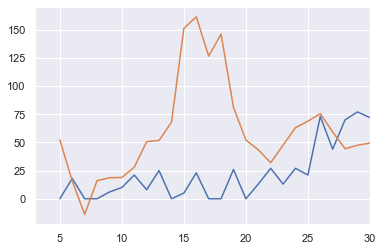

In [493]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

#cdc_df = pd.read_csv("data/states/colorado/colorado_excess_deaths.csv", error_bad_lines=True)
cdc_df = pd.read_csv("data/states/utah/utah_excess_deaths.csv", error_bad_lines=True)
actual_deaths = cdc_df[(cdc_df['Week'] >= 5) & (cdc_df['Week'] <= 30)].groupby([ 'Week'])['Excess Higher Estimate'].sum()
actual_deaths_df = actual_deaths.to_frame(name = 'actual_excess_deaths').reset_index()
pred_deaths = predicted_df_all_days.groupby(['Week'])['Predicted_Weekly_Excess_Deaths'].sum()
pred_deaths_df = pred_deaths.to_frame(name = 'pred_excess_deaths').reset_index()

fig, axs = plt.subplots(1)
x = actual_deaths_df['Week']
y = actual_deaths_df['actual_excess_deaths']
z = pred_deaths_df['pred_excess_deaths']
plt.xlim(3,30)

axs.plot(x, y)
axs.plot(x, z)

plt.savefig('pred_actual_2weeks.png')



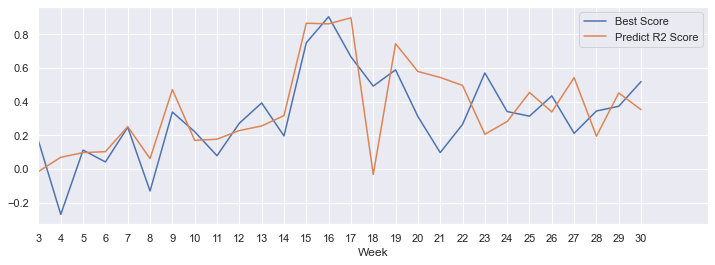

<Figure size 432x288 with 0 Axes>

In [344]:
import seaborn as sns

def drawGraphs(best_fit_scores, cat):
    sns.set()

    x = best_fit_scores['Week Duration']
    y = best_fit_scores['Best_Score']
    z = best_fit_scores['Predict_R2_Score']

    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)

    plt.xlim(0,30)
    plt.xlabel('Week')

    ax.plot(x, y, label ='Best Score')

    ax.plot(x, z, label ='Predict R2 Score')
    plt.legend()
    plt.show()
    plt.savefig(cat + '_r2_score.png')
    
drawGraphs(best_fit_scores, 'Pred_Actual')


#x = weekly_deaths_df[(weekly_deaths_df['county'] == 8031.0) & (weekly_deaths_df['week'] > 4)]['week']
#y = weekly_deaths_df[(weekly_deaths_df['county'] == 8031.0) & (weekly_deaths_df['week'] > 4)]['excess_deaths_per100k']
#z = predicted_df_all_days[(predicted_df_all_days['FIPS'] == 8031.0)]['Predicted_Weekly_Deaths']
#plt.plot(x, y)
#plt.plot(x, z)